In [2]:
!pip install pymorphy2
import zipfile
import os
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
import pymorphy2
import string
morph = pymorphy2.MorphAnalyzer()
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 8.0 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
with zipfile.ZipFile('corpus_news (1).zip', 'r') as z:
    z.extractall('corpus_news')

In [4]:
def ziptodoc(folder):
    doc = []
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), 'r', encoding='utf-8') as f:
            try:
              text = f.read()
              doc.append(text)
            except UnicodeDecodeError:
              pass
    return doc

In [5]:
culture = ziptodoc('corpus_news/corpus/culture')
tech = ziptodoc('corpus_news/corpus/hi-tech')
politics = ziptodoc('corpus_news/corpus/politics')
science = ziptodoc('corpus_news/corpus/science')

In [6]:
culture = pd.DataFrame({'content':culture, 'target': '0'})
hitech = pd.DataFrame({'content':tech, 'target': '1'})
politics = pd.DataFrame({'content':politics, 'target': '2'})
science = pd.DataFrame({'content':science, 'target': '3'})


In [7]:
data = pd.concat([culture, hitech, politics, science])


In [8]:
data

,content,target
0,"Трижды муж Валерий Баринов рассказал, как долг...",0
1,"Звезда ""Очень странных дел"" станцевал в Антарк...",0
2,"""Москва слезам не верит"": Раиса Рязанова в 199...",0
3,"На китайском телевидении запретили рэп, хип-хо...",0
4,"В Москве открыли первый детский центр ""Союзмул...",0
...,...,...
206,"Астрономы впервые выяснили, из чего состоят зе...",3
207,Поиск потайных комнат в гробнице Тутанхамона: ...,3
208,Вулканологи обнаружили под тропическим острово...,3
209,Впервые восстановлены полные геномы живых и вы...,3


In [9]:
sw = open(r'swl (1).txt', encoding='utf8')
swlist = []  
for i in sw:
    i = i.replace('\n','')
    swlist.append(i)

In [10]:
def pre(text):
  
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = re.sub("\d+", "", text)
  text = text.lower()
  tokens = nltk.word_tokenize(text)
  no_sw = []
  for token in tokens: 
    token = morph.parse(token)[0].normal_form
    if token not in swlist:
       no_sw.append(token)     
  text = ' '.join(no_sw)
  
  return text

In [11]:
data['content']=data['content'].apply(pre)


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
documents = data['content'].values.astype("U")

vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(documents)

k = 4
model = KMeans(n_clusters=k, init='k-means++', max_iter=600, n_init=1)
model.fit(features)

print("Cluster centroids: \n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(k):
    print("Cluster %d:" % i)
    for j in order_centroids[i, :10]: 
        print (' %s' % terms[j])
    print('------------')

Cluster centroids: 

Cluster 0:
 компания
 новый
 учёный
 человек
 смартфон
 apple
 пользователь
 исследование
 google
 устройство
------------
Cluster 1:
 фильм
 актёр
 театр
 артист
 спектакль
 дочь
 жизнь
 режиссёр
 роль
 крым
------------
Cluster 2:
 президент
 россия
 сша
 кандидат
 путин
 трамп
 выборы
 санкция
 российский
 страна
------------
Cluster 3:
 сирия
 украина
 россия
 оон
 саакашвили
 лавров
 сирийский
 украинский
 российский
 киев
------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


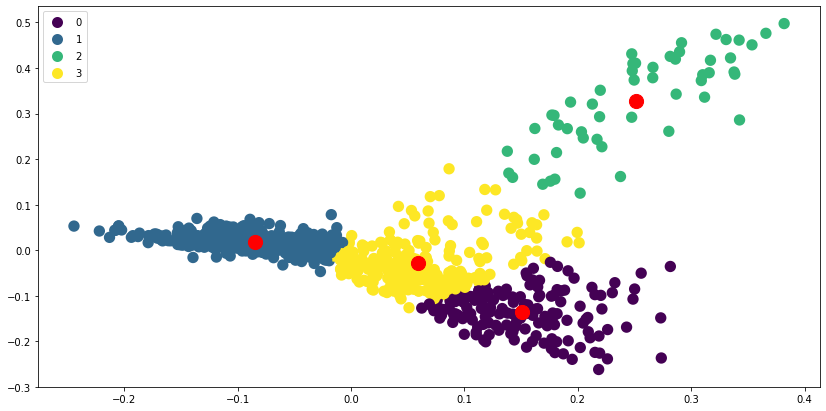

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components = 2)

X = pca.fit_transform(features.toarray())
fitted = model.fit(X)
prediction = model.predict(X)
data['k-means cluster preds'] = model.labels_
plt.figure(figsize=(14, 7))

scat = plt.scatter(X[:, 0], X[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)
plt.legend(*scat.legend_elements())

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='red', s=200, alpha=1);

<Figure size 1008x504 with 0 Axes>

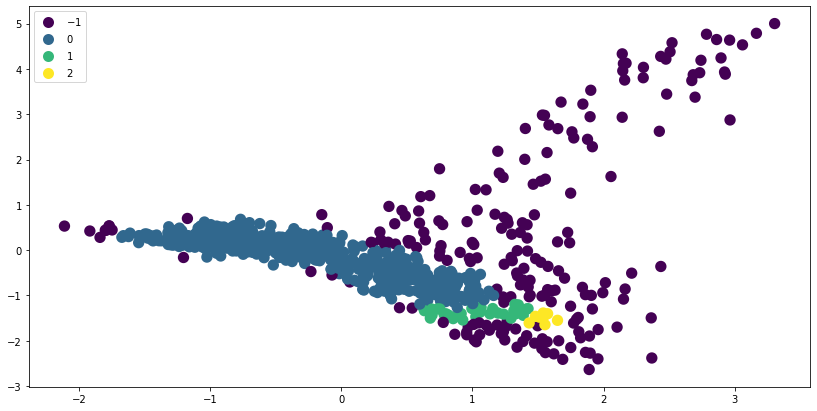

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
model = DBSCAN(eps=0.15, min_samples=10)
model.fit(X)
data['DBSCAN cluster preds'] = model.labels_
plt.figure(figsize=(14, 7))
plt.figure(figsize=(14, 7))
scat = plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=40, cmap='viridis', linewidths=5)
plt.legend(*scat.legend_elements())


In [16]:
from sklearn.metrics import silhouette_score
sil_sc = silhouette_score(X, model.labels_, metric='euclidean')
print(f'Silhouette score: {sil_sc}')

Silhouette score: 0.31369473376743673


<Figure size 1008x504 with 0 Axes>

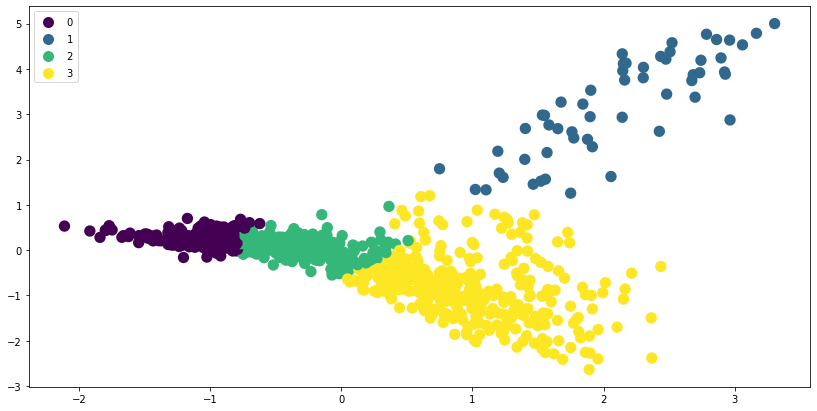

In [17]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters= 4,
    eigen_solver="arpack",
        affinity="nearest_neighbors")
model.fit(X)
data['SC cluster preds'] = model.labels_
plt.figure(figsize=(14, 7))
plt.figure(figsize=(14, 7))
scat = plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=40, cmap='viridis', linewidths=5)
plt.legend(*scat.legend_elements())

In [18]:
sil_sc = silhouette_score(X, model.labels_, metric='euclidean')
print(f'Silhouette score: {sil_sc}')

Silhouette score: 0.41156520280023884


<Figure size 1008x504 with 0 Axes>

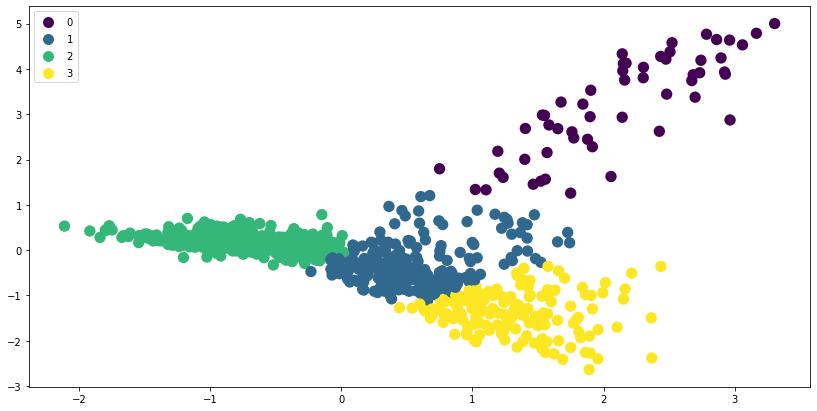

In [19]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(
        n_clusters=4, linkage="ward")
model.fit(X)
data['WARD cluster preds'] = model.labels_
plt.figure(figsize=(14, 7))
plt.figure(figsize=(14, 7))
scat = plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=40, cmap='viridis', linewidths=5)
plt.legend(*scat.legend_elements())

In [20]:
sil_sc = silhouette_score(X, model.labels_, metric='euclidean')
print(f'Silhouette score: {sil_sc}')

Silhouette score: 0.5408858791632677


<Figure size 1008x504 with 0 Axes>

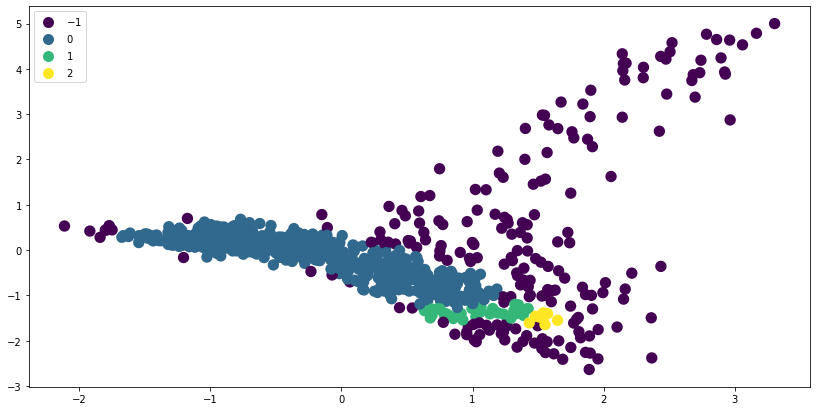

In [24]:
X = StandardScaler().fit_transform(X)
model = DBSCAN(eps=0.15,min_samples=10)
model.fit(X)
data['DBSCAN cluster preds'] = model.labels_
plt.figure(figsize=(14, 7))
plt.figure(figsize=(14, 7))
scat = plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=40, cmap='viridis', linewidths=5)
plt.legend(*scat.legend_elements())

In [25]:
sil_sc = silhouette_score(X, model.labels_, metric='euclidean')
print(f'Silhouette score: {sil_sc}')

Silhouette score: 0.3132193301853121


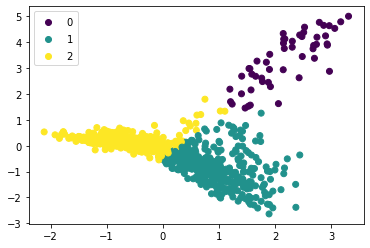

In [26]:
from sklearn import cluster
model = cluster.AffinityPropagation(damping= 0.9,  preference= -200, random_state=0)
model.fit(X)
y_pred = model.predict(X)
data['AP cluster preds'] = y_pred

scatter = plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.legend(*scatter.legend_elements())
plt.show()

In [27]:
sil_sc = silhouette_score(X, model.labels_, metric='euclidean')
print(f'Silhouette score: {sil_sc}')

Silhouette score: 0.6058017364247893


<Figure size 1008x504 with 0 Axes>

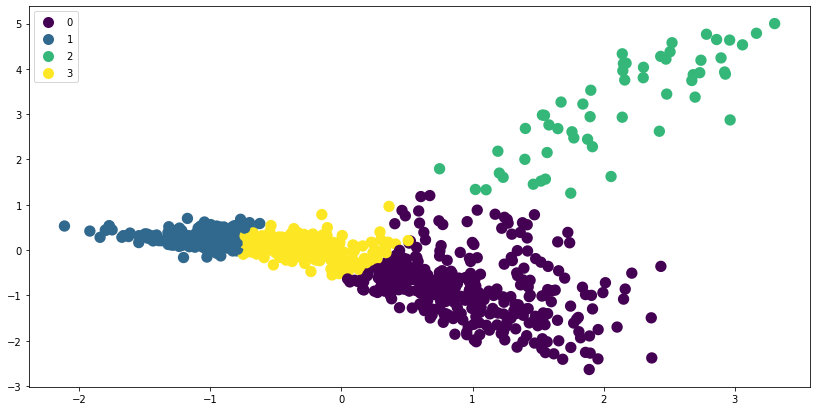

In [28]:
model = SpectralClustering(n_clusters= 4,
    eigen_solver="arpack",
        affinity="nearest_neighbors")
model.fit(X)
data['SC cluster preds'] = model.labels_
plt.figure(figsize=(14, 7))
plt.figure(figsize=(14, 7))
scat = plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=40, cmap='viridis', linewidths=5)
plt.legend(*scat.legend_elements())

In [29]:
sil_sc = silhouette_score(X, model.labels_, metric='euclidean')
print(f'Silhouette score: {sil_sc}')

Silhouette score: 0.4158475197609606


<Figure size 1008x504 with 0 Axes>

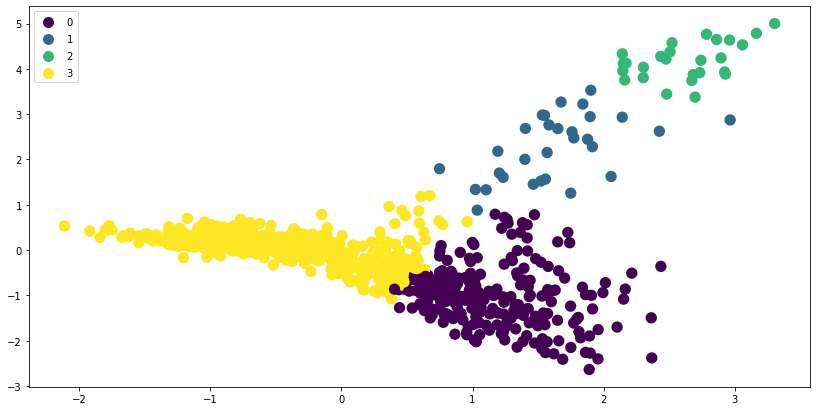

In [32]:
model = AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=4,
    )

model.fit(X)
data['AC cluster preds'] = model.labels_
plt.figure(figsize=(14, 7))
plt.figure(figsize=(14, 7))
scat = plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=40, cmap='viridis', linewidths=5)
plt.legend(*scat.legend_elements())

In [33]:
sil_sc = silhouette_score(X, model.labels_, metric='euclidean')
print(f'Silhouette score: {sil_sc}')

Silhouette score: 0.5898892414456752
